In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import Counter

In [2]:
data_path = './data/train'
# Main data
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

# Side Information
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

### train_ratings 데이터

- 31,360명의 유저
- 6,807개의 영화
- 데이터의 sparsity ratio는 약 97.6%로 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터


#### **유저, 영화별 그룹핑**
[유저]   
- 영화를 가장 적게 본 유저 : 16개
- 영화를 가장 많이 본 유저 : 2912개
- 75%의 데이터가 200개 안에 존재   

[영화]   
- 가장 적은 유저가 본 영화 : 27명
- 가장 많은 유저가 본 영화 : 19,699명
- 50%-197, 75%-610 안에 존재
   
[년도]   
- 고유 년도별 아이템 수:  6799개 -> 결측치 8개 -> title로 채움
- 고유 년도 수:  93개
- 가장 많은 영화가 개봉한 년도 : 2006년, 284개 (상위 10개년도 - 2001~2010)
- 가장 적은 영화가 개봉한 년도 : 1923년, 2개
- 년도별 평균 개봉 영화 수 : 73개   


[장르]
- 고유한 아이템 수 : 6807개
- 고유한 장르 수 : 18개
- 한 영화당 장르 수 : 1개 ~ 10개
- 장르 순위 : 드라마 -> 코미디 -> 스릴러 -> ... -> 필름 느와르

[작가]
- 고유 영화(item) 수 : 5648개 -> 결측치 존재
- 고유 작가(writer) 수 : 2989명
- 영화당 작가 참여 수 : 1개 ~ 24개 (75%까지 2개)
- 작가당 영화 참여 수 : 2개 ~ 47개 (평균 3.78개, 75%까지 4개)
- 작가가 없는 영화 수 : 1159개

[감독]
- 고유 영화(item) 수 : 5503개 -> 결측치 존재
- 고유 감독(director) 수 : 1340
- 영화당 감독 참여 수 : 1개 ~ 14개 (75%까지 1개)
- 감독당 영화 참여 수 : 2개 ~ 44개 (평균 4.4개, 75%까지 5개)
- 감독이 없는 영화 수 : 1304개

[작가 & 감독]
- 작가와 감독에 모두 포함된 인원 수 :  676명
- 작가와 감독이 모두 없는 영화 수 :  629개
- 작가 겸 감독이 포함된 영화 수 : 2829개 -> 겸하는 사람들은 다작을 하는 사람일 가능성이 높음
- 감독 겸 작가가 포함된 영화 수 : 3090개 -> 겸하는 사람들은 다작을 하는 사람일 가능성이 높음

In [3]:
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [4]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Number of unique train users:  31360
Number of unique train items:  6807
Data sparsity ratio:  0.9758536052697853


In [5]:
user_group = train_df.groupby('user', as_index=False).apply(len).rename(columns={None:"cnt_item"})
item_group = train_df.groupby('item', as_index=False).apply(len).rename(columns={None:"cnt_user"})
user_group = user_group.sort_values('cnt_item')
item_group = item_group.sort_values('cnt_user')

count    31360.000000
mean       164.364509
std        150.009107
min         16.000000
25%         71.000000
50%        114.000000
75%        200.000000
max       2912.000000
Name: cnt_item, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


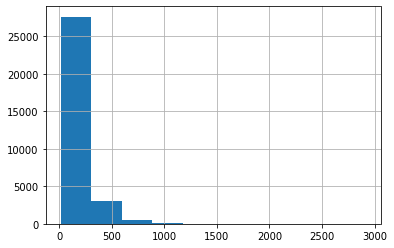

In [6]:
print(user_group.cnt_item.describe())
print(user_group.cnt_item.hist())

count     6807.000000
mean       757.230939
std       1682.973090
min         27.000000
25%         90.000000
50%        197.000000
75%        610.500000
max      19699.000000
Name: cnt_user, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


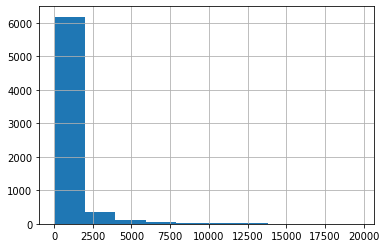

In [7]:
print(item_group.cnt_user.describe())
print(item_group.cnt_user.hist())

In [8]:
year_items = year_data.groupby("year").apply(len)
year_items_sort = year_items.sort_values()
year_items.describe()

count     93.000000
mean      73.107527
std       78.501656
min        2.000000
25%       19.000000
50%       37.000000
75%      100.000000
max      284.000000
dtype: float64

In [9]:
print(year_items_sort[:5])
print(year_items_sort[-5:])

year
1923    2
1926    2
1922    3
1930    4
1924    5
dtype: int64
year
2008    256
2005    260
2004    262
2007    271
2006    284
dtype: int64


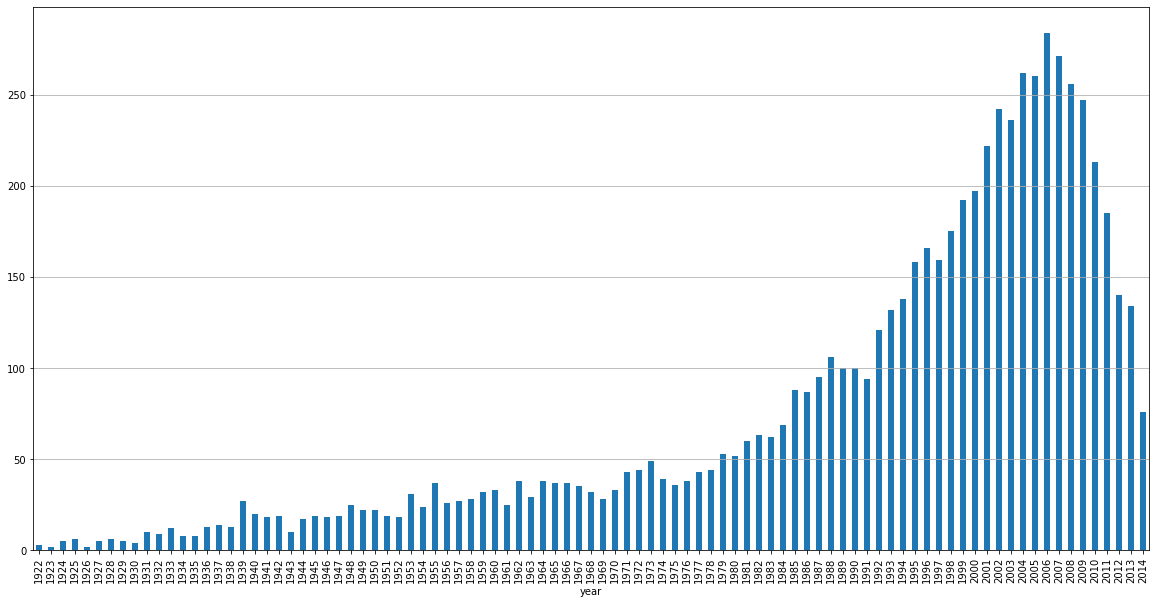

In [10]:
plt.figure(figsize=(20,10))
year_items.plot(kind='bar').grid(visible=True, axis='y')

In [11]:
all_train = train_df.copy()
all_train['time_date'] = pd.to_datetime(all_train['time'], unit='s')
all_train['time_year'] = all_train['time_date'].dt.year
all_train['time_month'] = all_train['time_date'].dt.month
all_train['time_hour'] = all_train['time_date'].dt.hour
all_train['time_day'] = all_train['time_date'].dt.dayofweek
all_train.head()

,user,item,time,time_date,time_year,time_month,time_hour,time_day
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,4,3
1,11,170,1230782534,2009-01-01 04:02:14,2009,1,4,3
2,11,531,1230782539,2009-01-01 04:02:19,2009,1,4,3
3,11,616,1230782542,2009-01-01 04:02:22,2009,1,4,3
4,11,2140,1230782563,2009-01-01 04:02:43,2009,1,4,3


In [12]:
print(all_train['time_date'].min())
print(all_train['time_date'].max())

2005-04-11 11:56:25
2015-03-31 05:50:52


In [13]:
title_data[title_data['title'].duplicated(keep=False)]

,item,title
349,34048,War of the Worlds (2005)
1926,64997,War of the Worlds (2005)


In [14]:
all_train = pd.merge(all_train, title_data)
all_train.head()

,user,item,time,time_date,time_year,time_month,time_hour,time_day,title
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,4,3,Planet of the Apes (2001)
1,189,4643,1302945016,2011-04-16 09:10:16,2011,4,9,5,Planet of the Apes (2001)
2,294,4643,1288437662,2010-10-30 11:21:02,2010,10,11,5,Planet of the Apes (2001)
3,383,4643,1261996844,2009-12-28 10:40:44,2009,12,10,0,Planet of the Apes (2001)
4,421,4643,1190624541,2007-09-24 09:02:21,2007,9,9,0,Planet of the Apes (2001)


In [15]:
print('고유 year_data item 수: ', year_data.item.nunique())
print('고유 year_data year 수: ', year_data.year.nunique())

고유 year_data item 수:  6799
고유 year_data year 수:  93


In [16]:
not_year = set(all_train['item']) - set(year_data['item'])
print('연도(year)가 없는 영화(id) 수: ', len(not_year))
df_not_year = all_train[all_train['item'].isin(not_year)][['item', 'title']].drop_duplicates().reset_index(drop=True)
df_not_year

연도(year)가 없는 영화(id) 수:  8


,item,title
0,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ..."
1,3310,"Kid, The (1921)"
2,7243,Intolerance: Love's Struggle Throughout the Ag...
3,8511,"Immigrant, The (1917)"
4,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ..."
5,7065,"Birth of a Nation, The (1915)"
6,119145,Kingsman: The Secret Service (2015)
7,6988,Broken Blossoms or The Yellow Man and the Girl...


In [17]:
df_add_year = pd.DataFrame([[i, int(title[title.rfind('(')+1:-1])] for i, title in df_not_year.values], columns=['item', 'year'])
df_add_year

,item,year
0,6987,1920
1,3310,1921
2,7243,1916
3,8511,1917
4,32898,1902
5,7065,1915
6,119145,2015
7,6988,1919


In [18]:
all_train = pd.merge(all_train, pd.concat([year_data, df_add_year]))
all_train

,user,item,time,time_date,time_year,time_month,time_hour,time_day,title,year
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,4,3,Planet of the Apes (2001),2001
1,189,4643,1302945016,2011-04-16 09:10:16,2011,4,9,5,Planet of the Apes (2001),2001
2,294,4643,1288437662,2010-10-30 11:21:02,2010,10,11,5,Planet of the Apes (2001),2001
3,383,4643,1261996844,2009-12-28 10:40:44,2009,12,10,0,Planet of the Apes (2001),2001
4,421,4643,1190624541,2007-09-24 09:02:21,2007,9,9,0,Planet of the Apes (2001),2001
...,...,...,...,...,...,...,...,...,...,...
5154466,126426,102880,1386260290,2013-12-05 16:18:10,2013,12,16,3,After Earth (2013),2013
5154467,127766,102880,1386261575,2013-12-05 16:39:35,2013,12,16,3,After Earth (2013),2013
5154468,130972,102880,1391096866,2014-01-30 15:47:46,2014,1,15,3,After Earth (2013),2013
5154469,131347,102880,1370143675,2013-06-02 03:27:55,2013,6,3,6,After Earth (2013),2013


[장르]

In [19]:
print('고유 장르 아이템 수: ', genre_data.item.nunique())
print('고유 장르 수: ', genre_data.genre.nunique())
genre_data['item'].value_counts()

고유 장르 아이템 수:  6807
고유 장르 수:  18


81132     10
26701      8
4719       7
2987       7
56152      7
          ..
27329      1
86852      1
103624     1
97673      1
8130       1
Name: item, Length: 6807, dtype: int64

<AxesSubplot:>

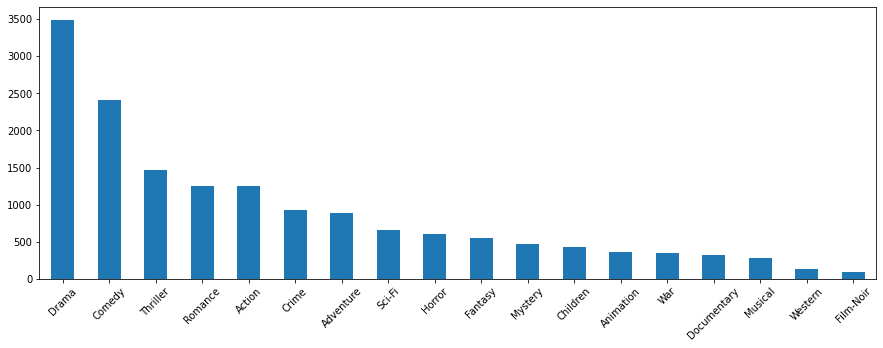

In [20]:
plt.figure(figsize=(15, 5))
genre_data['genre'].value_counts().plot(kind='bar', rot=45)

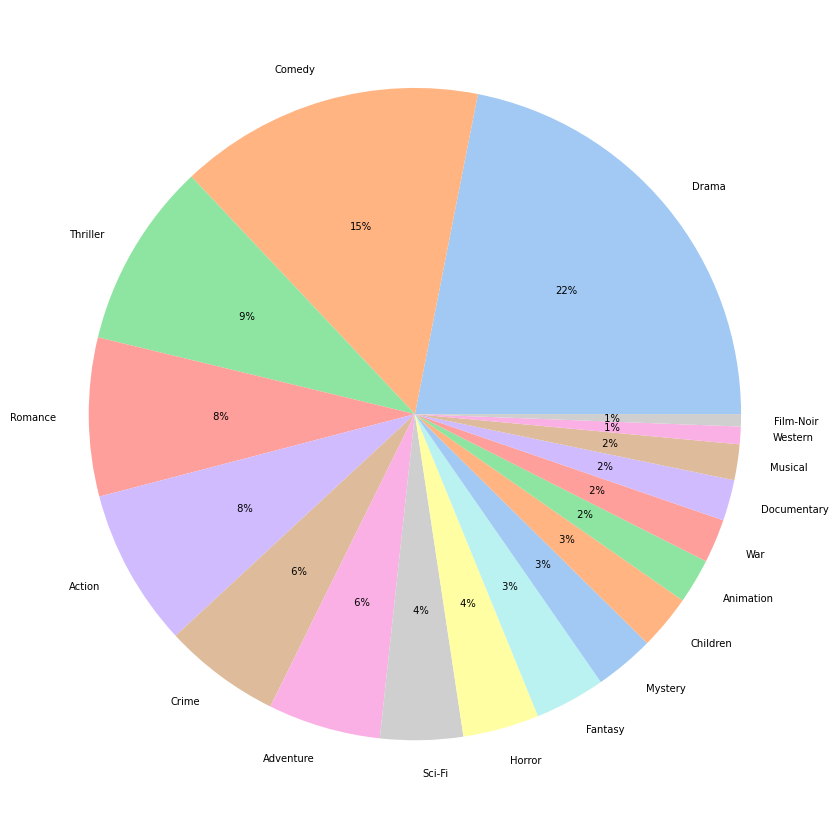

In [21]:
# genre별 등장 횟수 파이 차트
plt.figure(figsize=(15, 15))
labels, data = zip(*genre_data['genre'].value_counts().items())
plt.pie(data, labels=labels, colors=sns.color_palette('pastel'), autopct='%2.f%%')
plt.show()

[작가]
- 고유 영화(item) 수 : 5648개 -> 결측치 존재
- 고유 작가(writer) 수 : 2989명
- 영화당 작가 참여 수 : 1개 ~ 24개 (75%까지 2개)
- 작가당 영화 참여 수 : 2개 ~ 47개 (평균 3.78개, 75%까지 4개)
- 작가가 없는 영화 수 : 1159개

In [22]:
print('고유 영화(item) 수: ', writer_data.item.nunique())
print('고유 작가(writer) 수: ', writer_data.writer.nunique())
writer_data['item'].value_counts()  # 영화당 작가 참여 수 

고유 영화(item) 수:  5648
고유 작가(writer) 수:  2989


1907     24
783      23
364      21
2687     21
48322    19
         ..
79073     1
176       1
2560      1
42007     1
1237      1
Name: item, Length: 5648, dtype: int64

In [23]:
writer_data['item'].value_counts().describe()

count    5648.000000
mean        2.001771
std         1.546859
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        24.000000
Name: item, dtype: float64

In [24]:
writer_data['writer'].value_counts().describe()

count    2989.000000
mean        3.782536
std         2.993783
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        47.000000
Name: writer, dtype: float64

In [25]:
# 각본가가 없는 영화 수
not_writer = set(all_train['item']) - set(writer_data['item'])
print('작가가 없는 영화 수 : ', len(not_writer))
df_not_writer = all_train[all_train['item'].isin(not_writer)][['item', 'title']].drop_duplicates().reset_index(drop=True)
df_not_writer

작가가 없는 영화 수 :  1159


,item,title
0,170,Hackers (1995)
1,5151,40 Days and 40 Nights (2002)
2,33585,9 Songs (2004)
3,1225,Amadeus (1984)
4,59418,"American Crime, An (2007)"
...,...,...
1154,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
1155,79590,"Rebound, The (2009)"
1156,90524,Abduction (2011)
1157,75395,Frozen (2010)


[감독]
- 고유 영화(item) 수 : 5503개 -> 결측치 존재
- 고유 감독(director) 수 : 1340
- 영화당 감독 참여 수 : 1개 ~ 14개 (75%까지 1개)
- 감독당 영화 참여 수 : 2개 ~ 44개 (평균 4.4개, 75%까지 5개)
- 감독이 없는 영화 수 : 1304개
- 작가와 감독에 모두 포함된 인원 수 :  676

In [26]:
print('고유 영화(item) 수: ', director_data.item.nunique())
print('고유 감독(director) 수: ', director_data.director.nunique())

고유 영화(item) 수:  5503
고유 감독(director) 수:  1340


In [27]:
director_data['item'].value_counts().describe()

count    5503.000000
mean        1.073051
std         0.420017
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        14.000000
Name: item, dtype: float64

In [28]:
director_data['director'].value_counts().describe()

count    1340.000000
mean        4.406716
std         3.633030
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        44.000000
Name: director, dtype: float64

In [29]:
# 감독이 없는 영화 수
not_director = set(all_train['item']) - set(director_data['item'])
print('감독이 없는 영화 수 : ', len(not_director))
df_not_director = all_train[all_train['item'].isin(not_director)][['item', 'title']].drop_duplicates().reset_index(drop=True)
df_not_director

감독이 없는 영화 수 :  1304


,item,title
0,1591,Spawn (1997)
1,2793,"American Werewolf in Paris, An (1997)"
2,33085,"Amityville Horror, The (2005)"
3,31184,Appleseed (Appurushîdo) (2004)
4,34338,"Aristocrats, The (2005)"
...,...,...
1299,82093,London Boulevard (2010)
1300,75395,Frozen (2010)
1301,842,Tales from the Crypt Presents: Bordello of Blo...
1302,5999,Heavy Metal 2000 (2000)


In [30]:
same_writer_director = set(director_data['director']) & set(writer_data['writer'])
print('작가와 감독에 모두 포함된 인원 수 : ', len(same_writer_director))
not_writer_director = set(all_train['item']) - set(director_data['item']) & set(all_train['item']) - set(writer_data['item'])
print('작가와 감독이 모두 없는 영화 수 : ', len(not_writer_director))
df_not_writer_director = all_train[all_train['item'].isin(not_writer_director)][['item', 'title']].drop_duplicates().reset_index(drop=True)
df_not_writer_director

작가와 감독에 모두 포함된 인원 수 :  676
작가와 감독이 모두 없는 영화 수 :  629


,item,title
0,34338,"Aristocrats, The (2005)"
1,2827,"Astronaut's Wife, The (1999)"
2,36509,"Cave, The (2005)"
3,172,Johnny Mnemonic (1995)
4,27608,Immortel (ad vitam) (Immortal) (2004)
...,...,...
624,52227,"Darwin Awards, The (2006)"
625,84613,Sanctum (2011)
626,7304,Allegro non troppo (1977)
627,79590,"Rebound, The (2009)"


In [31]:
writer_direc = set(writer_data[writer_data['writer'].isin(same_writer_director)].item)
director_write = set(director_data[director_data['director'].isin(same_writer_director)].item)
print(len(writer_direc), len(director_write))

2829 3090


In [32]:
df_writer_direc  = all_train[all_train['item'].isin(writer_direc)][['item', 'title']].drop_duplicates().reset_index(drop=True)
df_writer_direc

,item,title
0,2140,"Dark Crystal, The (1982)"
1,2313,"Elephant Man, The (1980)"
2,2600,eXistenZ (1999)
3,8169,*batteries not included (1987)
4,58293,"10,000 BC (2008)"
...,...,...
2824,66762,Paris (2008)
2825,117881,Still Alice (2014)
2826,6478,"Life and Times of Judge Roy Bean, The (1972)"
2827,842,Tales from the Crypt Presents: Bordello of Blo...


In [33]:
df_director_write = all_train[all_train['item'].isin(director_write)][['item', 'title']].drop_duplicates().reset_index(drop=True)
df_director_write

,item,title
0,4643,Planet of the Apes (2001)
1,531,"Secret Garden, The (1993)"
2,2140,"Dark Crystal, The (1982)"
3,2313,"Elephant Man, The (1980)"
4,2428,"Faculty, The (1998)"
...,...,...
3085,31973,Germany Year Zero (Germania anno zero) (Deutsc...
3086,66762,Paris (2008)
3087,117881,Still Alice (2014)
3088,6478,"Life and Times of Judge Roy Bean, The (1972)"


In [34]:
all_train.head()

,user,item,time,time_date,time_year,time_month,time_hour,time_day,title,year
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,4,3,Planet of the Apes (2001),2001
1,189,4643,1302945016,2011-04-16 09:10:16,2011,4,9,5,Planet of the Apes (2001),2001
2,294,4643,1288437662,2010-10-30 11:21:02,2010,10,11,5,Planet of the Apes (2001),2001
3,383,4643,1261996844,2009-12-28 10:40:44,2009,12,10,0,Planet of the Apes (2001),2001
4,421,4643,1190624541,2007-09-24 09:02:21,2007,9,9,0,Planet of the Apes (2001),2001


개봉년도와 유저의 평가이력 비교

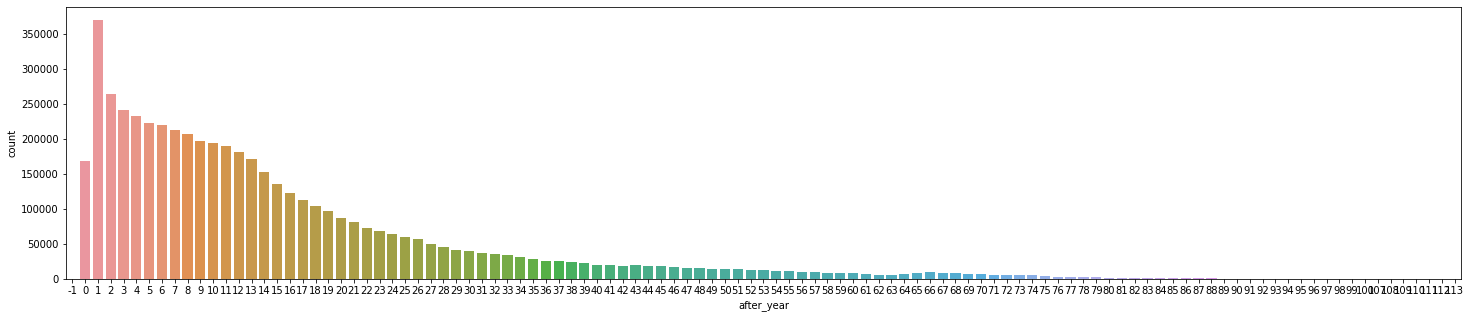

In [35]:
all_train['after_year'] = all_train['time_year'] - all_train['year']

plt.figure(figsize=(25, 5))
sns.countplot(x=all_train['after_year'])
plt.show()

In [36]:
all_train['after_year'].describe().apply("{0:.5f}".format)

count    5154471.00000
mean          15.24343
std           15.22697
min           -1.00000
25%            5.00000
50%           11.00000
75%           20.00000
max          113.00000
Name: after_year, dtype: object

<AxesSubplot:>

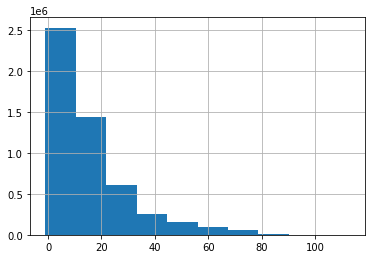

In [37]:
all_train['after_year'].hist()

In [38]:
all_train.head()

,user,item,time,time_date,time_year,time_month,time_hour,time_day,title,year,after_year
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,4,3,Planet of the Apes (2001),2001,8
1,189,4643,1302945016,2011-04-16 09:10:16,2011,4,9,5,Planet of the Apes (2001),2001,10
2,294,4643,1288437662,2010-10-30 11:21:02,2010,10,11,5,Planet of the Apes (2001),2001,9
3,383,4643,1261996844,2009-12-28 10:40:44,2009,12,10,0,Planet of the Apes (2001),2001,8
4,421,4643,1190624541,2007-09-24 09:02:21,2007,9,9,0,Planet of the Apes (2001),2001,6


[유저별 선호 장르]

In [112]:
all_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5154471 entries, 0 to 5154470
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user        int64         
 1   item        int64         
 2   time        int64         
 3   time_date   datetime64[ns]
 4   time_year   int64         
 5   time_month  int64         
 6   time_hour   int64         
 7   time_day    int64         
 8   title       object        
 9   year        int64         
 10  after_year  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 471.9+ MB


In [114]:
user_genre_table.sort_values('user')

,user,item,genre
0,11,170,"[Action, Adventure, Crime, Thriller]"
267992,11,364,"[Adventure, Animation, Children, Drama, Musical]"
97110,11,27728,"[Action, Animation, Drama, Sci-Fi, Thriller]"
277560,11,231,"[Adventure, Comedy]"
131621,11,4446,"[Adventure, Animation, Fantasy, Sci-Fi]"
...,...,...,...
179784,138493,784,"[Comedy, Thriller]"
405065,138493,7153,"[Action, Adventure, Drama, Fantasy]"
557266,138493,1101,"[Action, Romance]"
569749,138493,6754,"[Action, Fantasy, Horror]"


In [116]:
user_genre_table.groupby('user')['genre'].apply(list).reset_index()

,user,genre
0,11,"[[Action, Adventure, Crime, Thriller], [Advent..."
1,14,"[[Adventure, Drama], [Adventure, Comedy, Sci-F..."
2,18,"[[Comedy, Drama, Romance, War], [Crime, Horror..."
3,25,"[[Mystery, Sci-Fi, Thriller], [Children, Drama..."
4,31,"[[Action, Fantasy, War], [Adventure, Animation..."
...,...,...
31350,138473,"[[Mystery, Sci-Fi, Thriller], [Action, Fantasy..."
31351,138475,"[[Drama, Sci-Fi, Thriller], [Animation, Childr..."
31352,138486,"[[Adventure, Comedy, Sci-Fi, Western], [Action..."
31353,138492,"[[Adventure, Comedy, Fantasy], [Action, Advent..."


In [123]:
user_all_genre = user_genre_table.groupby('user')['genre'].apply(list).reset_index()
user_all_genre['all_genre'] = user_all_genre['genre'].apply(lambda x: Counter(chain(*x)).most_common())
user_all_genre

,user,genre,all_genre
0,11,"[[Action, Adventure, Crime, Thriller], [Advent...","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ..."
1,14,"[[Adventure, Drama], [Adventure, Comedy, Sci-F...","[(Comedy, 28), (Adventure, 22), (Children, 21)..."
2,18,"[[Comedy, Drama, Romance, War], [Crime, Horror...","[(Drama, 6), (Crime, 5), (Comedy, 4), (Thrille..."
3,25,"[[Mystery, Sci-Fi, Thriller], [Children, Drama...","[(Comedy, 13), (Adventure, 11), (Drama, 10), (..."
4,31,"[[Action, Fantasy, War], [Adventure, Animation...","[(Action, 19), (Adventure, 18), (Fantasy, 13),..."
...,...,...,...
31350,138473,"[[Mystery, Sci-Fi, Thriller], [Action, Fantasy...","[(Thriller, 11), (Drama, 10), (Mystery, 8), (F..."
31351,138475,"[[Drama, Sci-Fi, Thriller], [Animation, Childr...","[(Drama, 10), (Thriller, 10), (Crime, 7), (Fil..."
31352,138486,"[[Adventure, Comedy, Sci-Fi, Western], [Action...","[(Comedy, 21), (Adventure, 19), (Horror, 18), ..."
31353,138492,"[[Adventure, Comedy, Fantasy], [Action, Advent...","[(Action, 7), (Adventure, 6), (Comedy, 6), (Ro..."


In [125]:
# 장르 그룹핑
all_genre = genre_data.groupby('item')['genre'].apply(list).drop_duplicates().reset_index()
user_genre_table = pd.merge(all_train[['user', 'item']], all_genre)

# 유저별 장르 그룹핑
user_all_genre = user_genre_table.groupby('user')['genre'].apply(list).reset_index()
user_all_genre['all_genre'] = user_all_genre['genre'].apply(lambda x: Counter(chain(*x)).most_common())
user_all_genre['top_genre'] = user_all_genre['all_genre'].apply(lambda x: dict(x[0:3]).keys())

all_train = pd.merge(user_genre_table, user_all_genre[['user', 'all_genre', 'top_genre']])

all_train.head()

,user,item,genre,all_genre,top_genre
0,11,170,"[Action, Adventure, Crime, Thriller]","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ...","(Sci-Fi, Action, Adventure)"
1,11,2140,"[Adventure, Fantasy]","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ...","(Sci-Fi, Action, Adventure)"
2,11,3113,"[Action, Fantasy, Horror, Mystery, Thriller]","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ...","(Sci-Fi, Action, Adventure)"
3,11,8169,"[Children, Comedy, Fantasy, Sci-Fi]","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ...","(Sci-Fi, Action, Adventure)"
4,11,58293,"[Adventure, Romance, Thriller]","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ...","(Sci-Fi, Action, Adventure)"


In [127]:
user_all_genre.head(20)

,user,genre,all_genre,top_genre
0,11,"[[Action, Adventure, Crime, Thriller], [Advent...","[(Sci-Fi, 47), (Action, 46), (Adventure, 45), ...","(Sci-Fi, Action, Adventure)"
1,14,"[[Adventure, Drama], [Adventure, Comedy, Sci-F...","[(Comedy, 28), (Adventure, 22), (Children, 21)...","(Comedy, Adventure, Children)"
2,18,"[[Comedy, Drama, Romance, War], [Crime, Horror...","[(Drama, 6), (Crime, 5), (Comedy, 4), (Thrille...","(Drama, Crime, Comedy)"
3,25,"[[Mystery, Sci-Fi, Thriller], [Children, Drama...","[(Comedy, 13), (Adventure, 11), (Drama, 10), (...","(Comedy, Adventure, Drama)"
4,31,"[[Action, Fantasy, War], [Adventure, Animation...","[(Action, 19), (Adventure, 18), (Fantasy, 13),...","(Action, Adventure, Fantasy)"
5,35,"[[Action, Fantasy, War], [Action, Animation, D...","[(Thriller, 17), (Action, 16), (Drama, 16), (C...","(Thriller, Action, Drama)"
6,43,"[[Adventure, Drama], [Adventure, Animation, Ch...","[(Adventure, 4), (Drama, 4), (Romance, 4), (Co...","(Adventure, Drama, Romance)"
7,50,"[[Mystery, Sci-Fi, Thriller], [Adventure, Dram...","[(Drama, 13), (Adventure, 9), (Fantasy, 7), (S...","(Drama, Adventure, Fantasy)"
8,58,"[[Mystery, Sci-Fi, Thriller], [Children, Drama...","[(Drama, 27), (Action, 22), (Comedy, 21), (Thr...","(Drama, Action, Comedy)"
9,60,"[[Adventure, Comedy, Fantasy], [Adventure, Dra...","[(Adventure, 13), (Fantasy, 8), (Comedy, 7), (...","(Adventure, Fantasy, Comedy)"


In [128]:
user_all_genre[['user', 'all_genre', 'top_genre']].to_csv('user_like_genre.csv', index=False)